In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
from sklearn import linear_model
from numpy.fft import fft, fftfreq
from nfft import nfft, nfft_adjoint
from astropy.stats import LombScargle
import time
# in order to use custom modules in parent path
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

# then import some modules
#from mfilter.implementations.simulate import SimulateSignal

# extra config for ploting
%matplotlib inline
plt.style.use('seaborn')

## Fourier Transform with Signal Decomposition

here we are going to try several alternative ways to do a fourier transform, we look for a method that could estimate the fourier transform using the logic of singal decomposition, for a signal $s(t) = \vec{s}$ we decompose this signal into coeficients ($\vec{\beta}$) using a dictionary $\Phi$ which is a matrix where every column is an atom ($\vec{\phi}_k = \Phi_{j,k}\: \forall j$) for the decomposition, these atoms will be sines and cosines for a given frequency ($k \in \{f_{min}, ..., f_{max}\}$) in all times:

$$ (\vec{s})_j = (\Phi \cdotp \vec{\beta})_j = \sum_k (\phi_k)_j \beta_k $$
#### Ridge Regresion with penalization
this a method of minimization by Least Square using norm $L^{2}$ modified with a penalization to avoid the linear dependence that make a normal Lest Square method fail. The coeficient of penalization should be found with cross validation.

#### LASSO 
Another method to try is LASSO which can find the coeficient using a norm $L^{1}$, this aslo implemente extra coeficiente of penalization which should be found by cross validation


### Using evenly sampled data
frist we try this method for data evenly sampled and compare with a Fast Fourier Transform implemented in numpy to check the correct behavior.

In [2]:
#### generate data
def gen_data(N, freq=None, time_interval=None, dwindow=None, noisy=False):
    if freq is None:
        freq = 10
    if time_interval is None:
        t_i = 0
        t_f = 1
    else:
        t_i = time_interval[0]
        t_f = time_interval[1]
    if dwindow is None:
        dwindow = signal.tukey(N, alpha=1./8)
        
    t = np.linspace(t_i, t_f, N)
    data = 0.4*np.sin(2 * np.pi * freq * t) + 0.4*np.sin(2 * np.pi * 2 * freq * t) + 0.2*np.sin(2 * np.pi * 4 * freq * t) 
    if noisy:
        data += np.random.normal(0, 0.5, N)
    data *= dwindow
    return data, t

N =41

dwindow = signal.tukey(N, alpha=1./8)
data, t = gen_data(N, freq=5,time_interval=[0, 1], dwindow=dwindow, noisy=False)
dt = t[1] - t[0]
print("the sampling rate necessary to satisfy nyquist-shannon is: {} and ge have: {}".format(20 * 2, 
                                                                                              round(1/dt, 1)))
# estimate the nyquist limit and the sampling spacer df
factor = 10
nyq =  1 / (2 * dt)
print("the nyquist limit is: ", nyq)
df = 1 / (max(t) - min(t)) / factor

# get the frequency grid, considering the 0 frequency
k = np.linspace(0, nyq, int(nyq / df) + 1)
# k = (-(N//2) + np.arange(N))*df

# compute the fourier matrix
F = np.exp(2j*np.pi*t.reshape(-1, 1)*k)

# see that this fourier matrix is oversampled
print("Num of Frequencies in the Matrix: {} and Times: {}".format(F.shape[1], F.shape[0]))

the sampling rate necessary to satisfy nyquist-shannon is: 40 and ge have: 40.0
the nyquist limit is:  20.0
Num of Frequencies in the Matrix: 201 and Times: 41


#### Checking that Regression only work with real features and data

In [3]:
# check if this method support complex features
a = np.exp(-2)
ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
# complex
ridge.fit(F, data)
coef = ridge.coef_

# cosine
ridge.fit(F.real, data)
coef_cos = ridge.coef_

print("the method use only real numbers: ", np.allclose(coef, coef_cos))

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


the method use only real numbers:  True


#### Observation:
this method, and we supose all the methods implemented in sklearn for regressions, use only real number. This will mean that if we use directly a Fourier Dictionary with atoms:

$$ \vec{\phi}_k = e^{2\pi i t_j k} \: \forall j$$

Sklearn will do the decomposition of the signal using a Cosine Dictionary (real part):

$$ \vec{\phi}_k = (e^{2\pi i t_j k}).real = cos(2 \pi i t_j k) \: \forall j $$

causing a loss in the phase information. To solve this we will try to split the Fourier Dictionario and create a new Dictionary of Cosines and sines by separate:

$$ (\Phi)_{j,k} = \begin{cases}
cos(2 \pi i t_j \omega_k) & \text{if } 0 \leq k < L/2 \\
sin(2 \pi i t_j \omega_k) & \text{if } L/2 \leq k < L
\end{cases}$$

Where $L$ correspond to twice the original number of frequencies(i.e. atoms) used, and $\omega_k = \{f_{min}, ..., f_{max}, f_{min}, ..., f_{max}\}$ will be the original frequencies twice. 

To get the Fourier Transform value we Combine this coeficients $\beta$ followin the rule of: 
* the k-element of the Fourier Transform will be equal to $\beta[k] + i \beta[k + L/2]$

And to reconstruct the data, we just need to do the dot product:
$$ \vec{s} = \Phi \cdotp \vec{\beta}$$

#### Implement Ridge regression, LASSO, Elastic NET and Orthogonal Matching Pursuit

nyquist-shannon satisfied
the nyquist limit is:  99.5
Num of Frequencies in the Fourier Matrix: 498 and Times: 200
alpha parameter for ridge is: 0.005
alpha parameter for lasso is: 0.005
alpha parameter for elasticnet is: 0.005


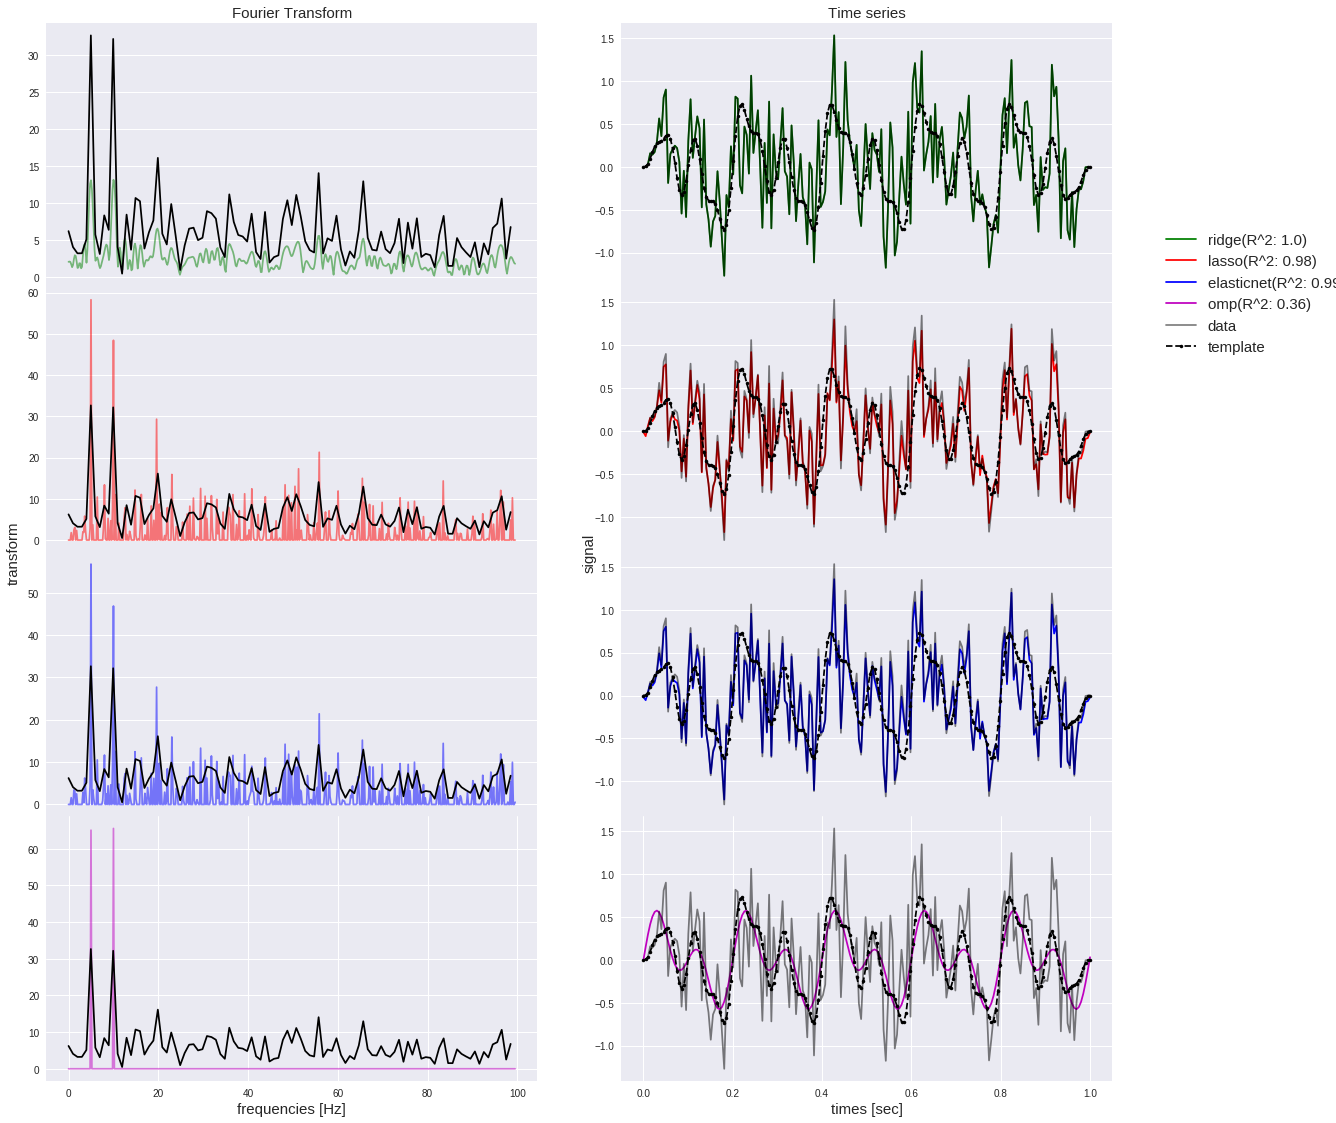

In [4]:
def regression(X, y, model_type="ridge", alpha=0.01, l1_ratio=0.7):
    vec_alphas = 10**np.linspace(-10, 0, 10)
    vec_alphas = [0.005]
    if model_type is "ridge":
        reg = linear_model.RidgeCV(alphas=vec_alphas, fit_intercept=False, cv=4)
    elif model_type is "lasso":
        reg = linear_model.LassoCV(alphas=vec_alphas, cv=4)
    elif model_type is "elasticnet":
        reg = linear_model.ElasticNetCV(alphas=vec_alphas, l1_ratio=l1_ratio, cv=4)
    elif model_type is "omp":
        reg = linear_model.OrthogonalMatchingPursuitCV(fit_intercept=True, cv=4)
    else:
        raise ValueError("model_type {}  not implemented".format(model_type))
    reg.fit(X, y)
    if model_type not in ["omp"]:
        print("alpha parameter for {} is: {}".format(model_type, reg.alpha_))
    return reg.coef_, np.dot(X, reg.coef_), reg.score(X, y)

def cast_into_FT(coefs):
    n_freqs = int(len(coefs) / 2)
    ft = 1j * np.zeros(n_freqs)
    for i in range(n_freqs):
        ft[i] = coefs[i] + 1j * coefs[i + n_freqs]
    
    if len(ft) != n_freqs:
        raise ValueError("fail")
    return ft

def test_fourier(N, dwindow=None, freq=None, time_interval=None, noisy=False, oversampling_factor=5):
    if dwindow is None:
        dwindow = signal.tukey(N, alpha=1./8)
        
    data, t = gen_data(N, freq=freq, time_interval=time_interval, dwindow=dwindow, noisy=noisy)
    temp, _ = gen_data(N, freq=freq, time_interval=time_interval, dwindow=dwindow, noisy=False)
    dt = t[1] - t[0]
    if freq * 2 < 1/dt:
        print("nyquist-shannon satisfied")
        
    # estimate the nyquist limit and the sampling spacer df
    nyq =  1 / (2 * dt)
    print("the nyquist limit is: ", nyq)
    df = 1 / (max(t) - min(t)) / oversampling_factor
    
    # get the frequency grid, considering the 0 frequency
    k = np.linspace(0, nyq, int(nyq / df) + 1)
    
    F = np.exp(2j*np.pi*t.reshape(-1, 1)*k)
    print("Num of Frequencies in the Fourier Matrix: {} and Times: {}".format(F.shape[1], F.shape[0]))
    
    F_splited = np.hstack((F.real, F.imag))
    method_type=["ridge", "lasso", "elasticnet", "omp"]
    colors = {"ridge": "g", "lasso": "r", "elasticnet": "b", "omp": "m"}
    fig, axs = plt.subplots(len(method_type), 2, figsize=(16, 4 * len(method_type)))
    leg2 = []
    times_cost = []
    for i in range(len(method_type)):
        t_i = time.time()
        coef, predicted, score = regression(F_splited, data, model_type=method_type[i])
        t_f = time.time()
        times_cost.append(t_f - t_i)
        axs[i][0].get_xaxis().set_visible(False)
        axs[i][1].get_xaxis().set_visible(False)
        axs[i][0].plot(k, np.abs(cast_into_FT(coef))*F_splited.shape[0], colors[method_type[i]], 
                       alpha=0.5)
#         axs[i][0].plot(fftfreq(N, d=dt)[:N//2], fft(data)[N//2], 'k', )
        lg1 = axs[i][1].plot(t, predicted, colors[method_type[i]], 
                             label=method_type[i] + "(R^2: {})".format(round(score, 2)))
#         axs[i][1].plot(t, data, 'k')
        leg2.append(lg1)
    axs[len(method_type)-1][0].get_xaxis().set_visible(True)
    axs[len(method_type)-1][1].get_xaxis().set_visible(True)
    for i in range(len(method_type)-1):
        axs[i][0].plot(fftfreq(N, d=dt)[:N//2], np.abs(fft(data)[:N//2]), 'k')
        axs[i][1].plot(t, data, 'k', alpha=0.5)
        axs[i][1].plot(t, temp, 'k.--')
        
    axs[len(method_type)-1][0].plot(fftfreq(N, d=dt)[:N//2], np.abs(fft(data)[:N//2]), 'k')
    lg1 = axs[len(method_type)-1][1].plot(t, data, 'k', alpha=0.5, label="data")
    lg11 = axs[len(method_type)-1][1].plot(t, temp, 'k.--', label="template")
    leg2.append(lg1)
    axs[0][0].set_title("Fourier Transform",  fontsize=15)
    axs[0][1].set_title("Time series",  fontsize=15)
    axs[len(method_type)-1][0].set_xlabel("frequencies [Hz]",  fontsize=15)
    axs[len(method_type)-1][1].set_xlabel("times [sec]",  fontsize=15)
    
    fig.add_subplot(121, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.grid(False)
    plt.ylabel(r"transform", fontsize=15)
    
    fig.add_subplot(122, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.grid(False)
    plt.ylabel(r"signal", fontsize=15)
    
    fig.legend(handles=leg2.append(lg11), loc='center left', bbox_to_anchor=(1, 0.72), fontsize=15)
    plt.tight_layout()
    fig.subplots_adjust(hspace=0)
    return F_splited, data, t, k, times_cost
    
X, y, t, k, t_cost = test_fourier(200, freq=5, time_interval=[0, 1], noisy=True) 

In [13]:
print(t_cost)

[0.05217146873474121, 1.1987519264221191, 1.0597541332244873, 0.27854418754577637]


0.009204387664794922
0.999999999317744


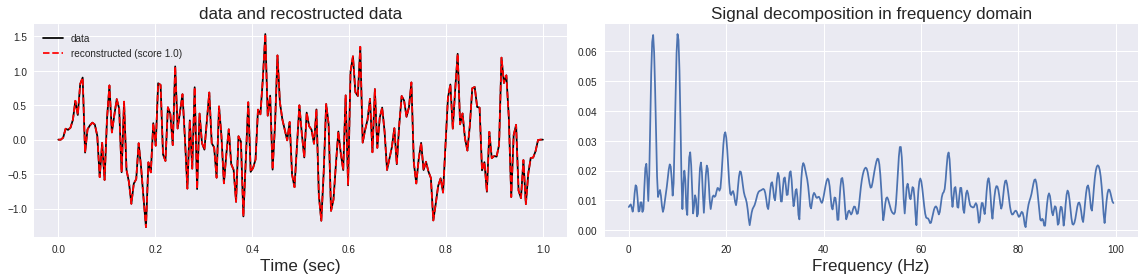

In [15]:
t_i = time.time()
clf = linear_model.SGDRegressor(max_iter=10)
clf.fit(X, y)
t_f = time.time()
print(t_f - t_i)
print(clf.score(X, y))
# clf is a trained model

y_predicted = clf.predict(X)
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(t, y, 'k', label="data")
ax1.plot(t, y_predicted, 'r--', label="reconstructed (score {})".format(round(clf.score(X, y), 2)))
ax1.legend()
ax2.plot(k, np.abs(cast_into_FT(clf.coef_)))
ax1.set_title("data and recostructed data", fontsize=17)
ax2.set_title("Signal decomposition in frequency domain", fontsize=17)
ax1.set_xlabel("Time (sec)", fontsize=17)
ax2.set_xlabel("Frequency (Hz)", fontsize=17)
plt.tight_layout()
plt.savefig("regressor.png")

#### Using unevenly-sampled data
then we will try this method for unevenly sampled data and compare with a Non Uniform Fast Fourier Transform implemented by Jake VanderPlas to check the correct behavior.

* First create the unevenly time measures, for this we simulate slight deviation with

$$ t_j =j\Delta t + \epsilon(j)$$

where $\Delta t$ is an underlying time spacing and $\epsilon(j)$ is a random gaussian distribution with a small $\sigma$. Also we simulate some outlier meditions representing big intervals of time without observation, the most clearly exampled here is that observation of more than 1 night will have like 12 hours of no ovservation between nights. For this we just need to add a big splint in some point. One last thing could be a change in exposure time which leads to a change in the interval between medition, for this we just change the underlying time spacing by a factor $\gamma$.

$$t_j = j \gamma \Delta t + \epsilon(j)$$

In [ ]:
# testing that implementation doesn't fail
n_samples = 200
simulated = SimulateSignal(n_samples, [5, 10, 20], weights=[1, 1, 1], noise_level=0.2, underlying_delta=0.005)

config = "outlier"
times = simulated.get_times(configuration=config)
data = simulated.get_data(pos_start_peaks=20, n_peaks=4, with_noise=True,
                          configuration=config)
plt.figure()
plt.plot(times, data, '.--')

In [ ]:
ft = nfft_adjoint(times, data, n_samples)
k = (-(n_samples//2) + np.arange(n_samples)) / (max(times) - min(times))
plt.plot(k[n_samples//2:], np.abs(ft)[n_samples//2:])

In [ ]:
def test_fourier(N, dwindow="tukey", freq=None, weights=None, 
                 underlying_delta=0.005, noisy=False, oversampling_factor=5,
                 config="slight", pos_start_peaks=0, n_peaks=1, method_type=["ridge"]):
        
    simulated = SimulateSignal(N, freq, weights=weights, noise_level=0.2, 
                               dwindow=dwindow, underlying_delta=underlying_delta)
    times = simulated.get_times(configuration=config)
    data = simulated.get_data(pos_start_peaks=pos_start_peaks, n_peaks=n_peaks, with_noise=noisy,
                          configuration=config)
    temp = simulated.get_data(pos_start_peaks=pos_start_peaks, n_peaks=n_peaks, with_noise=False,
                          configuration=config)
    T = max(times) - min(times)
    if max(freq) * 2 < T/N:
        print("nyquist-shannon satisfied")
    # to avoid calculation of nyquist frequency, lets just say
    # a maximum frequency
    f_max = (N//2) / T
    
    # the sampling spacer df
    df = 1 / T / oversampling_factor

    # get the frequency grid, considering the 0 frequency
    k = np.linspace(0, f_max, int(f_max / df) + 1)
    k = (-((N*oversampling_factor)//2) + np.arange(N * oversampling_factor)) * df
    k_nfft = (-(N//2) + np.arange(N)) / T
    F = np.exp(2j*np.pi*times.reshape(-1, 1)*k)
    print("Num of Frequencies in the Fourier Matrix: {} and Times: {}".format(F.shape[1], F.shape[0]))
    
    F_splited = np.hstack((F.real, F.imag))
    colors = {"ridge": "g", "lasso": "r", "elasticnet": "b", "omp": "m"}
    fig, axs = plt.subplots(len(method_type), 2, figsize=(16, 4 * len(method_type)))
    leg2 = []
    for i in range(len(method_type)):
        coef, predicted, score = regression(F_splited, data, model_type=method_type[i])
        axs[i][0].get_xaxis().set_visible(False)
        axs[i][1].get_xaxis().set_visible(False)
        axs[i][0].plot(k, np.abs(cast_into_FT(coef))*F_splited.shape[0], colors[method_type[i]], 
                       alpha=0.5)
#         axs[i][0].plot(fftfreq(N, d=dt)[:N//2], fft(data)[N//2], 'k', )
        lg1 = axs[i][1].plot(times, predicted, colors[method_type[i]], 
                             label=method_type[i] + "(R^2: {})".format(round(score, 2)))
#         axs[i][1].plot(t, data, 'k')
        leg2.append(lg1)
    axs[len(method_type)-1][0].get_xaxis().set_visible(True)
    axs[len(method_type)-1][1].get_xaxis().set_visible(True)
    for i in range(len(method_type)-1):
        axs[i][0].plot(k_nfft, np.abs(nfft_adjoint(times, data, N)), 'k')
        axs[i][1].plot(times, nfft(times, nfft_adjoint(times, data, N))/N, 'k', alpha=0.5)
        axs[i][1].plot(times, temp, 'k.--')
        
    axs[len(method_type)-1][0].plot(k_nfft, np.abs(nfft_adjoint(times, data, N)), 'k')
    lg1 = axs[len(method_type)-1][1].plot(times, nfft(times, nfft_adjoint(times, data, N))/N, 
                                          'k', alpha=0.5, label="reconstructed data")
    lg11 = axs[len(method_type)-1][1].plot(times, temp, 'k.--', label="template")
    leg2.append(lg1)
    axs[0][0].set_title("Fourier Transform",  fontsize=15)
    axs[0][1].set_title("Time series",  fontsize=15)
    axs[len(method_type)-1][0].set_xlabel("frequencies [Hz]",  fontsize=15)
    axs[len(method_type)-1][1].set_xlabel("times [sec]",  fontsize=15)
    
    fig.add_subplot(121, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.grid(False)
    plt.ylabel(r"transform", fontsize=15)
    
    fig.add_subplot(122, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.grid(False)
    plt.ylabel(r"signal", fontsize=15)
    
    fig.legend(handles=leg2.append(lg11), loc='center left', bbox_to_anchor=(1, 0.72), fontsize=15)
    plt.tight_layout()
    fig.subplots_adjust(hspace=0)
    return F, k, df, data, times, temp

method_type=["ridge", "lasso", "elasticnet", "omp"]
method_type=["ridge", "elasticnet"]

F, k, df, data, times, temp = test_fourier(200, dwindow="tukey", freq=[10, 20], weights=[1, 0.5], 
             underlying_delta=0.005, noisy=True, oversampling_factor=5,
             config="outlier", pos_start_peaks=20, n_peaks=4, method_type=method_type)

In [ ]:

# extend to SNR
def SNR_signal_decomp(N, times, data, noise, temp, model_type="ridge", oversampling_factor=5):
    # to avoid calculation of nyquist frequency, lets just say
    # a maximum frequency
    T = max(times) - min(times)
    f_max = (N//2) / T
    # the sampling spacer df
    df = 1 / T / oversampling_factor
    f_min = 0
    
    # get the frequency grid, considering the 0 frequency
    Nf = 1 + int(np.round((f_max - f_min) / df))
    k = f_min + np.arange(Nf) * df
    
    F = np.exp(2j*np.pi*times.reshape(-1, 1)*k)
    
    F_splited = np.hstack((F.real, F.imag))
    
    coef_data, _, _ = regression(F_splited, data, model_type=model_type)
    coef_temp, _, _ = regression(F_splited, temp, model_type=model_type)
    coef_noise, _, _ = regression(F_splited, noise, model_type=model_type)
    
    data_ft = cast_into_FT(coef_data)
    temp_ft = cast_into_FT(coef_temp)
    noise_ft = cast_into_FT(coef_noise)
    print("freq 0 is: ", data_ft[0], temp_ft[0])
    plt.figure()
    plt.title("transforms (abs)")
    plt.plot(k, np.abs(data_ft), label="data ft")
    plt.plot(k, np.abs(temp_ft), label="temp ft conju")
    plt.legend()
    
    _, power = LombScargle(times, noise).autopower(maximum_frequency=f_max, minimum_frequency=df,
                                                         samples_per_peak=oversampling_factor, normalization="standard")
    print("len power: ", len(power))
    power = np.append(0.01, power)
    print("new len: ", len(power))
    plt.figure()
    plt.title("psd of noise")
    plt.plot(k, power)
    
    
    print(len(data_ft), len(temp_ft), len(power))
    norm_sigma = 4 * df
    h_norm = (temp_ft.conjugate() * temp_ft / power).sum()
#     h_norm = np.mean(noise_ft * temp_ft.conjugate() / power)
    norm_corr = 4 * df / np.sqrt(h_norm * norm_sigma)
#     corr = data_ft * temp_ft.conjugate() / power
    corr = np.divide(np.multiply(data_ft.conjugate(), temp_ft), power)
    
    plt.figure()
    plt.title("correlation (abs)")
    plt.plot(k, np.abs(corr))
    
    snr = np.dot(F, corr) * norm_corr
    snr = np.roll(snr, len(snr) // 2)
    return snr
    

n_samples = 500
freq = [0.00008, 0.001, 0.01]
weights=[1, 0.4, 0.2]
config="slight"
pos_start_peaks = 0
n_peaks = 1
simulated = SimulateSignal(n_samples, freq, weights=weights, noise_level=0.2, 
                           dwindow="tukey", underlying_delta=50)
times = simulated.get_times(configuration=config)
data = simulated.get_data(pos_start_peaks=pos_start_peaks, n_peaks=n_peaks, with_noise=True,
                          configuration=config)
noise = simulated.get_noise(None)
temp = simulated.get_data(pos_start_peaks=pos_start_peaks, n_peaks=n_peaks, with_noise=False,
                          configuration=config)
temp *= 1
T = max(times) - min(times)
if max(freq) * 2 < n_samples/T:
        print("nyquist-shannon satisfied")
else:
    print("nyquist-shannon not satisfied, you need an average sampling rate of: {} and yu have: {}".format(max(freq) * 2,
                                                                                                          n_samples/T))


snr = SNR_signal_decomp(n_samples, times, data, noise, temp, model_type="elasticnet")
plt.figure()
plt.plot(times, data)
plt.plot(times, temp)
plt.figure()
plt.plot(times - times[n_samples//2], snr, '.-')

In [ ]:
abs(snr).argmax()

In [ ]:
temp_test = np.roll(temp, 179)
plt.plot(times, data)
plt.plot(times, temp_test)